In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
% matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.applications.xception import Xception, preprocess_input

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

#TL pecific modules
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [2]:
X=[]
Z=[]
img_height, img_width = 100, 100
daisy_dir ='data/daisy'
sunflower_dir ='data/sunflower'
tulip_dir ='data/tulip'
dandelion_dir = 'data/dandelion'
rose_dir = 'data/rose'

In [3]:
def assign_label(img,flower_type):
    return flower_type   

In [4]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (img_height,img_width))
        
        X.append(np.array(img))
        Z.append(str(label))     

In [5]:
make_train_data('Daisy',daisy_dir)
print(len(X))

100%|██████████| 769/769 [00:00<00:00, 805.20it/s]

769


In [6]:
make_train_data('Sunflower', sunflower_dir)
print(len(X))

100%|██████████| 734/734 [00:01<00:00, 643.42it/s]

1503


In [7]:
make_train_data('Tulip',tulip_dir)
print(len(X))

100%|██████████| 984/984 [00:01<00:00, 742.42it/s]

2487


In [8]:
make_train_data('Dandelion', dandelion_dir)
print(len(X))

100%|██████████| 1052/1052 [00:01<00:00, 785.55it/s]

3539


In [9]:
make_train_data('Rose', rose_dir)
print(len(X))

100%|██████████| 784/784 [00:00<00:00, 830.02it/s]

4323


In [10]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

In [11]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [12]:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

In [13]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [14]:
epochs=15
batch_size=32
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=2, verbose=1)
droput_rate= 0.5
output_classes = 5

/home/sara/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:928: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.
  warnings.warn('`epsilon` argument is deprecated and '


In [15]:
def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.

    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)


In [16]:
xception_weights = 'pretrained-models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'

model = Sequential()

model.add(Xception(weights = xception_weights , include_top=False,pooling = 'avg'))
model.add(Dropout(rate=droput_rate))
model.add(Dense(units=output_classes, activation='softmax'))

model.layers[0].trainable = True

model.compile(loss='categorical_crossentropy',
              optimizer=adam_opt,
              metrics=['accuracy', fmeasure, recall, precision])

In [17]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/15
101/101 [==============================] - 339s 3s/step - loss: 1.6173 - acc: 0.2418 - fmeasure: 0.0245 - recall: 0.0130 - precision: 0.2624 - val_loss: 1.5268 - val_acc: 0.3469 - val_fmeasure: 0.0209 - val_recall: 0.0111 - val_precision: 0.2229
Epoch 2/15
101/101 [==============================] - 327s 3s/step - loss: 1.5117 - acc: 0.3462 - fmeasure: 0.0550 - recall: 0.0294 - precision: 0.5245 - val_loss: 1.3743 - val_acc: 0.4792 - val_fmeasure: 0.1564 - val_recall: 0.0879 - val_precision: 0.8705
Epoch 3/15
101/101 [==============================] - 327s 3s/step - loss: 1.3763 - acc: 0.4344 - fmeasure: 0.1634 - recall: 0.0935 - precision: 0.7685 - val_loss: 1.2175 - val_acc: 0.5449 - val_fmeasure: 0.3098 - val_recall: 0.1915 - val_precision: 0.8722
Epoch 4/15
101/101 [==============================] - 328s 3s/step - loss: 1.2362 - acc: 0.5245 - fmeasure: 0.3051 - recall: 0.1870 - precision: 0.8806 - val_loss: 1.0987 - val_acc: 0.5846 - val_fmeasure: 0.4329 - val_recall: 0.2

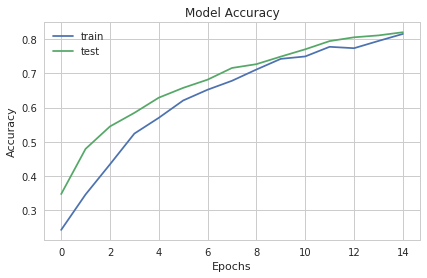

In [18]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

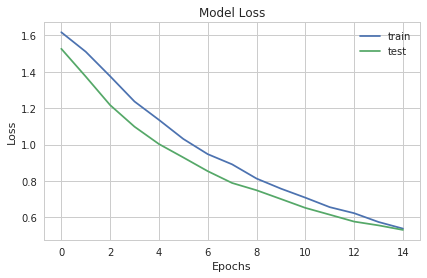

In [19]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

## 4 ) Visualizing Predictons on the Validation Set

In [24]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

In [28]:
len(pred_digits)

1081

In [29]:
len(pred)

1081

In [30]:
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

In [43]:
# Useful methods for plotting results
class HelperClass(object):
        
    # helper method
    @staticmethod
    def stars():
        print ("***********************")
    
    # print metrics as dataframe
    @staticmethod
    def print_dataframe(values):
    
        metrics_print = ['True Positive', 'True Negative', 'False Negative', 'False Positive',
    'Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 Score', 'Roc Auc Score']

        df_metrics = pd.DataFrame(
            {'Metrics': metrics_print,
             'Values': values
            })

        print (df_metrics.to_string(header=False, index=False))
        HelperClass.stars()
        
                
        
    # Disclaimer: metodo obtido em:
    # http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    # Metodo para plotar a matrix de confusao
    @staticmethod
    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix:")
        else:
            print('Confusion matrix, without normalization:')

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

        plt.show()




    # ROC curve
    @staticmethod
    def plot_roc_curve(y_true, y_scores):

        fpr, tpr, thresholds = roc_curve(y_true, y_scores)

        HelperClass.stars()
        print ("Roc Curve:")
        HelperClass.stars()

        plt.plot(fpr, tpr, label = 'ROC Curve', linewidth = 2)
        plt.plot([0,1],[0,1], 'k--', linewidth = 2)
        plt.title('ROC Curve')
        plt.xlim([0.0, 0.001])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()



    # Precision Recall Curve
    @staticmethod
    def plot_precision_recall_curve(y_true, y_scores):

        HelperClass.stars()
        print ("Precision Recall Curve:")
        HelperClass.stars()

        precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

        plt.step(recall, precision, color = 'b', alpha = 0.2, where = 'post')

        plt.plot(recall, precision, linewidth=2)
        plt.xlim([0.0,1.0])
        plt.ylim([0.0,1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve')
        plt.show()



    # Show classification report
    @staticmethod
    def show_full_classification_report(y_true, y_pred, y_scores, classes):

        HelperClass.stars()
        print ("Metrics Report:")
        HelperClass.stars()

        cm = confusion_matrix(y_true, y_pred)

        true_positive = cm[1,1]
        true_negative = cm[0,0]
        false_negative = cm[1,0]
        false_positive = cm[0,1]

        accuracy = ((true_positive + true_negative)/(true_positive + true_negative + false_negative + false_positive))
        precision = (true_positive/(true_positive + false_positive))
        recall = (true_positive/(true_positive + false_negative))  
        sensitivity = (true_positive/(true_positive + false_negative))  
        specificity = (true_negative/(true_negative + false_positive))  
        f1_score = ((2 * precision * recall)/(precision + recall))
        
        roc_auc = roc_auc_score(y_true, y_scores)

        print ("Classification Report:")
        HelperClass.stars()

        values = []

        values.append(true_positive)
        values.append(true_negative)
        values.append(false_negative)
        values.append(false_positive)
        values.append('{:.4f}'.format(accuracy))
        values.append('{:.4f}'.format(precision))
        values.append('{:.4f}'.format(recall))
        values.append('{:.4f}'.format(specificity))
        values.append('{:.4f}'.format(f1_score))
        values.append('{:.4f}'.format(roc_auc))

        HelperClass.print_dataframe(values)

        HelperClass.plot_confusion_matrix(cm, classes)

        HelperClass.plot_roc_curve(y_true, y_scores)

        HelperClass.plot_precision_recall_curve(y_true, y_scores)

In [33]:
score = model.evaluate(x_test, y_test, verbose=1)

1081/1081 [==============================] - 29s 27ms/step


In [34]:
y_pred = model.predict_proba(x_test)
y_pred_bool = np.zeros_like(y_pred)
y_pred_bool[np.arange(len(y_pred)), y_pred.argmax(1)] = 1

print (roc_auc_score(y_test, y_pred))
print (roc_auc_score(y_test, y_pred_bool))

0.9653668007873509
0.8874828016298386


In [35]:
def roc_auc_score_multiclass(actual_class, pred_class):
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict


In [37]:
actual_list = y_test.argmax(axis=1)
pred_list = y_pred_bool.argmax(axis=1)

In [38]:
roc_auc_score_multiclass(actual_list, pred_list)

{0: 0.8691514952708982,
 1: 0.9069917743830788,
 2: 0.8871628521655556,
 3: 0.8936492622020431,
 4: 0.8804586241276172}

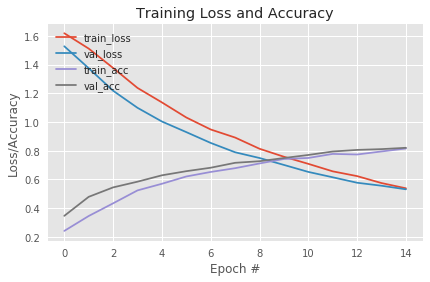

In [41]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), History.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), History.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), History.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), History.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

#### CORRECTLY CLASSIFIED FLOWER IMAGES

In [25]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

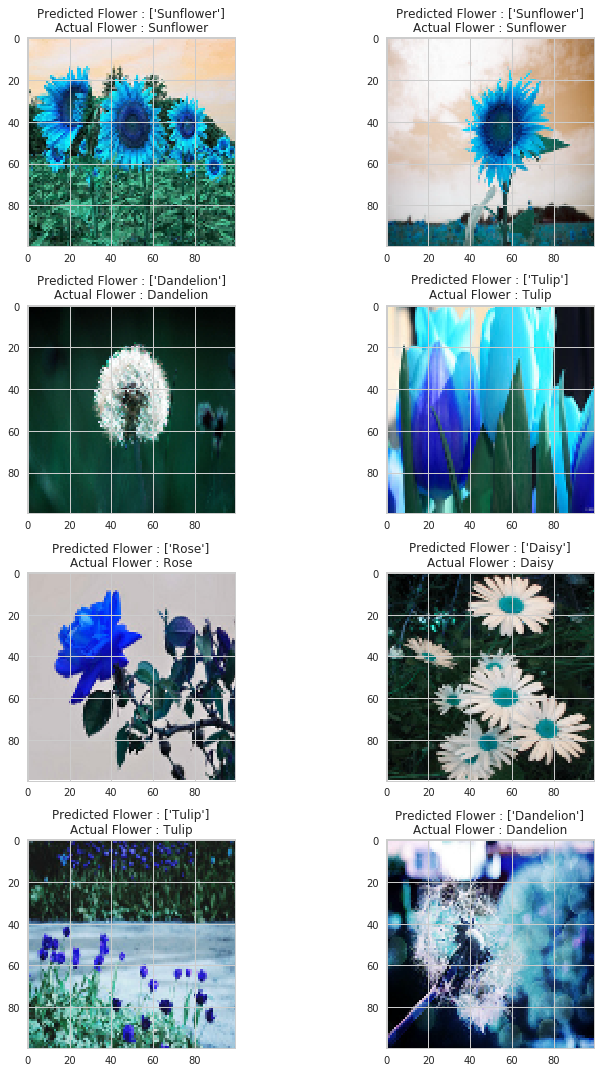

In [22]:
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[prop_class[count]]]))))
        plt.tight_layout()
        count+=1

#### MISCLASSIFIED IMAGES OF FLOWERS

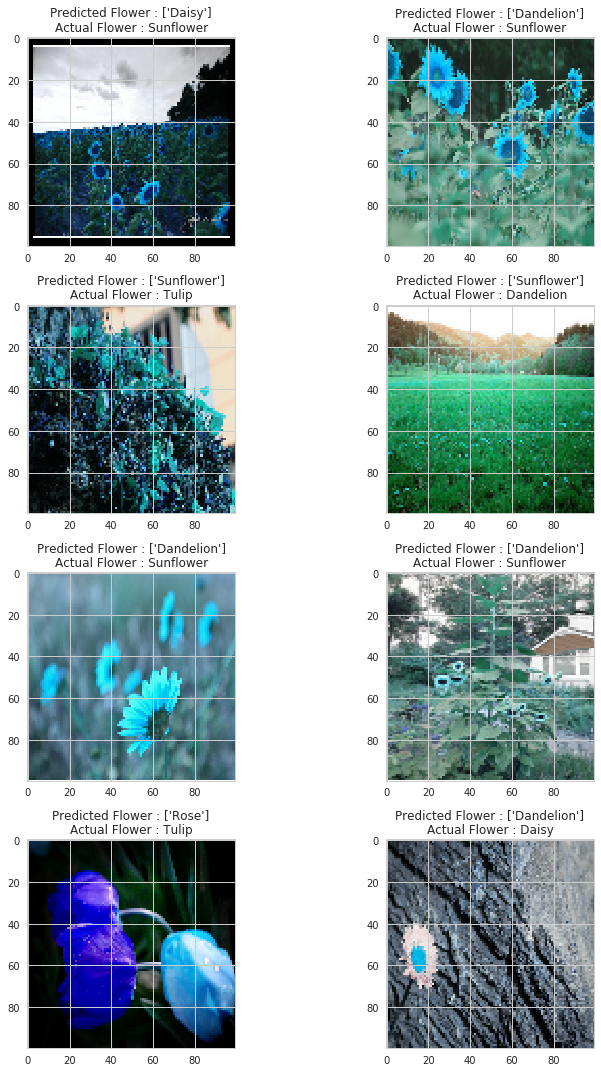

In [23]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[mis_class[count]]]))))
        plt.tight_layout()
        count+=1